In [81]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import statsmodels.api as sm
import pandas as pd
from numpy import random as rn
import pickle


with open('PriceData_Full.pkl', 'rb') as f:
    price_full = pickle.load(f)
    

name1 = ["JPM", "WMT", "CAT", "CVX"]
name2 = ["BAC", "TGT", "DE", "XOM"]

reward_matrix = []

for name in range(4):
    P1 = price_full[name1[name]]
    P2 = price_full[name2[name]]
    date = price_full["Date"]

    # 2022-06-01: 3124; 2023-05-30: 3373
    # 2023-01-03: 3272; 2023-06-26: 3391
    # 2020-01-03: 2517; 2020-12-28: 2765
    # 2020-02-03: 2537; 2020-07-22: 2655

    daterange = [[3124, 3373], [3272, 3391], [2517, 2765], [2537, 2655]]


    #Observe the range of the z-score
    #Warning: can't determine the range of z-score by looking at the plot because of the future function
    ratio = P1/P2


    #Parameters
    ins_window = 5
    long_window = 60
    fee = 0.0002
    trading_volume = 1
    deviation = 1.5
    closing = 1
    stoploss = 2


    #Calculate z-score using rolling window
    ins_ratio = ratio.rolling(ins_window).mean()
    long_mean = ratio.rolling(long_window).mean()
    long_std = ratio.rolling(long_window).std()
    z_rolling = (ins_ratio - long_mean) / long_std



    def Trade(price1, price2, volume, fee, capital, holding1, holding2):
        #Short 1, Long 2
        trading_capital = volume
        capital -= 2 * trading_capital * fee
        holding1 -= trading_capital / price1
        holding2 += trading_capital / price2
        return capital, holding1, holding2

    def Close(price1, price2, fee, capital, holding1, holding2):
        trading_capital = abs(holding1) * price1 + abs(holding2) * price2
        capital -= trading_capital * fee
        holding1 = 0
        holding2 = 0
        return capital, holding1, holding2

    #Start trading
    holding1 = 0
    holding2 = 0
    capital = 0
    capital_list = []
    holding1_list = []
    holding2_list = []
    action_list = [] #1: short P1, long P2, -1: long P1, short P2, 0: take profit, 2: stop loss, -2: no action

    open_capital = []
    reward_percentage_dic = {}
    reward_percentage = []
    reward_cumulative = []

    period = 2 
    for i in range(daterange[period][0], daterange[period][1] + 1):
        reward = 0
        #print(i)
        capital = capital + holding1 * (P1[i] - P1[i - 1]) + holding2 * (P2[i] - P2[i - 1])
        if z_rolling[i] > deviation and z_rolling[i] <= stoploss:
            #Short P1, Long P2
            action_list.append(1)
            if holding1 == 0 and holding2 == 0:
                capital, holding1, holding2 = Trade(P1[i], P2[i], trading_volume, fee, capital, holding1, holding2)
                
            if holding1 > 0 and holding2 < 0:
                capital, holding1, holding2 = Close(P1[i], P2[i], fee, capital, holding1, holding2)
                reward_percentage_dic[i] = capital - open_capital[-1]
                
                capital, holding1, holding2 = Trade(P1[i], P2[i], trading_volume, fee, capital, holding1, holding2)
            
            open_capital.append(capital)
                
        elif z_rolling[i] < -deviation and z_rolling[i] >= -stoploss:
            #Long P1, Short P2
            action_list.append(-1)
            if holding1 == 0 and holding2 == 0:
                capital, holding2, holding1 = Trade(P2[i], P1[i], trading_volume, fee, capital, holding2, holding1)
                
            elif holding1 < 0 and holding2 > 0:
                capital, holding2, holding1 = Close(P2[i], P1[i], fee, capital, holding2, holding1)
                reward_percentage_dic[i] = capital - open_capital[-1]
                
                capital, holding2, holding1 = Trade(P2[i], P1[i], trading_volume, fee, capital, holding2, holding1)

            open_capital.append(capital)
            
        elif abs(z_rolling[i]) <= closing or i == daterange[period][1]:
            #Close position 
            action_list.append(0) 
            if holding1 != 0:
                reward = 1  
            capital, holding1, holding2 = Close(P1[i], P2[i], fee, capital, holding1, holding2)
            
            if reward == 1:
                reward_percentage_dic[i] = capital - open_capital[-1]
            
            
        elif abs(z_rolling[i]) > stoploss:
            #Stop loss
            action_list.append(2)
            if holding1 != 0:
                reward = 1
            capital, holding1, holding2 = Close(P1[i], P2[i], fee, capital, holding1, holding2)
            
            if reward == 1:
                reward_percentage_dic[i] = capital - open_capital[-1]
        
        else:
            #No action
            action_list.append(-2)
        
        capital_list.append(capital)
        holding1_list.append(holding1)
        holding2_list.append(holding2)
        
        if i in reward_percentage_dic.keys():
            reward_percentage.append(reward_percentage_dic[i])
        else:
            reward_percentage.append(0)
        
          
        if i == daterange[period][0]:
            reward_cumulative.append(reward_percentage[-1])
        else:
            reward_cumulative.append(reward_cumulative[-1] + reward_percentage[-1])
    
    reward_matrix.append(reward_cumulative)
    print(f"{sum(reward_percentage) * 100}%")
    #plt.plot(reward_cumulative, label = name1[name] + "/" + name2[name])







2.9291141922857706%
4.1585383282094%
1.7849965934156706%
5.799972281445087%


In [82]:

Reward_frame = pd.DataFrame({"date": date[daterange[period][0]:daterange[period][1] + 1], "JPM/BAC": reward_matrix[0], "WMT/TGT": reward_matrix[1], "CAT/DE": reward_matrix[2], "CVX/XOM": reward_matrix[3]})
Reward_frame["date"] = pd.to_datetime(Reward_frame['date'], format = '%Y-%m-%d')
Reward_frame.set_index(['date'], inplace = True)

print(Reward_frame)

#plt.bar([x for x in range(1, len(reward_percentage) + 1)], reward_percentage)





             JPM/BAC   WMT/TGT   CAT/DE   CVX/XOM
date                                             
2020-01-03  0.000000  0.000000  0.00000  0.000000
2020-01-06  0.000000  0.000000  0.00000  0.000000
2020-01-07  0.000000  0.000000  0.00000  0.000000
2020-01-08  0.000000  0.000000  0.00000  0.000000
2020-01-09  0.000000  0.000000  0.00000  0.000000
...              ...       ...      ...       ...
2020-12-21  0.029291  0.041585  0.01785  0.066857
2020-12-22  0.029291  0.041585  0.01785  0.066857
2020-12-23  0.029291  0.041585  0.01785  0.066857
2020-12-24  0.029291  0.041585  0.01785  0.066857
2020-12-28  0.029291  0.041585  0.01785  0.058000

[249 rows x 4 columns]


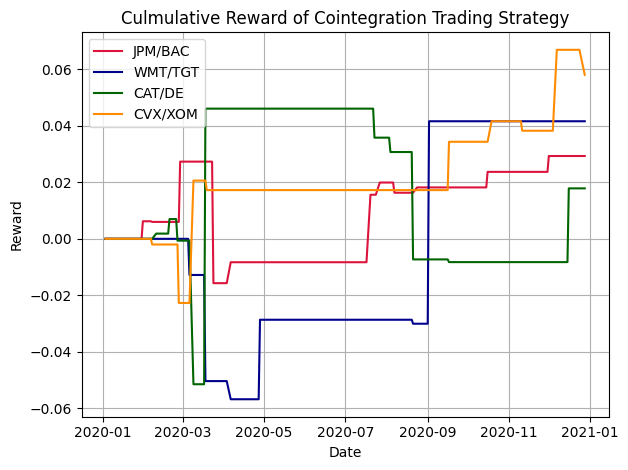

In [83]:
colors = ["crimson", "darkblue", "darkgreen", "darkorange"]

# Plotting
fig, ax = plt.subplots()

for column, color in zip(Reward_frame.columns, colors):
    ax.plot(Reward_frame.index, Reward_frame[column], label=column, color=color)

ax.set_title('Culmulative Reward of Cointegration Trading Strategy')
ax.set_xlabel('Date')
ax.set_ylabel('Reward')
ax.legend()  # Display a legend to identify each line
ax.grid(True)  # Turn on the grid for easier readability

plt.tight_layout()
#plt.show()

               WMT     TGT
date                      
2020-01-03  117.89  124.76
2020-01-06  117.65  123.58
2020-01-07  116.56  123.80
2020-01-08  116.16  123.40
2020-01-09  117.36  123.50
...            ...     ...
2023-06-16  155.53  133.81
2023-06-20  154.16  132.72
2023-06-21  154.46  133.22
2023-06-22  155.75  132.39
2023-06-23  155.46  131.83

[874 rows x 2 columns]


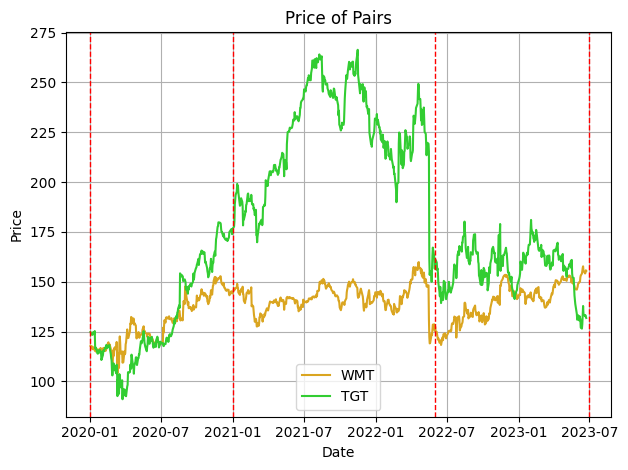

In [84]:
Price_frame = pd.DataFrame({"date": date[2517:3391], "WMT": price_full["WMT"][2517:3391], 
    "TGT": price_full["TGT"][2517:3391]})

Price_frame["date"] = pd.to_datetime(Price_frame['date'], format = '%Y-%m-%d')
Price_frame.set_index(['date'], inplace = True)

print(Price_frame)

colors = ['goldenrod', 'limegreen']

# Plotting
fig, ax = plt.subplots()

for column, color in zip(Price_frame.columns, colors):
    ax.plot(Price_frame.index, Price_frame[column], label=column, color=color)

important_dates = ["2022-06-01", "2020-01-01", "2021-01-01", "2023-07-01"]

# Add vertical lines
for date in important_dates:
    ax.axvline(pd.Timestamp(date), color='red', linestyle='--', linewidth=1)  # Customize color and style

ax.set_title('Price of Pairs')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()  # Display a legend to identify each line
ax.grid(True)  # Turn on the grid for easier readability

plt.tight_layout()
plt.show()